### 0. Imports and setup

In [3]:
from src.dataset import Colored3DMNIST, DataLoader
from torchvision import transforms, datasets
from IPython.display import clear_output
from matplotlib.colors import rgb2hex
from src.nn import UNet, ResNet_D
from src.plot import plot_img
from pathlib import Path
from tqdm import tqdm

import torch.nn.functional as F
import matplotlib.pyplot as plt
import src.data as data
import torch.nn as nn
import numpy as np
import torchvision
import torch
import gc

In [4]:
if torch.cuda.is_available():
    torch.cuda.set_device(f"cuda:0")
torch.manual_seed(42)
np.random.seed(42)

### 1. Getting the data ready

In [5]:
BATCH_SIZE = 32

def random_color(im):
    hue = np.random.choice([60, 120, 240, 280])
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

def Add_dimension(im):
    img_3D = torch.zeros(im.shape[0], im.shape[1], im.shape[2], 16)
    for i in range(im.shape[1]):
      if i < 6 or i > 10:
        img_3D[:, :, :, i] = torch.zeros_like(im)
      else:
        img_3D[:, :, :, i] = im
    return img_3D 

TRANSFORM_3D = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    random_color,
    Add_dimension,
])

# Load train datasets
mnist_train_a = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)

indices = mnist_train_a.targets == 3
mnist_train_a.data, mnist_train_a.targets = mnist_train_a.data[indices], mnist_train_a.targets[indices]

mnist_loader_a = torch.utils.data.DataLoader(mnist_train_a, batch_size=BATCH_SIZE, shuffle=True)


mnist_train_b = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)

indices = mnist_train_b.targets == 5
mnist_train_b.data, mnist_train_b.targets = mnist_train_b.data[indices], mnist_train_b.targets[indices]

mnist_loader_b = torch.utils.data.DataLoader(mnist_train_b, batch_size=BATCH_SIZE, shuffle=True)


mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM_3D)

indices = mnist_test.targets == 3
mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]

mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)

Let's plot a number:

In [6]:
def plot_img(img):
    fig = plt.figure()
    ax = plt.axes(projection="3d")

    color = np.array([rgb2hex(rgb) for rgb in img.numpy().reshape(3, -1).T])
    color = color.reshape(*img.shape[1:])
    
    if torch.any(img[0, ...]):
        img = img[0, ...]
    elif torch.any(img[1, ...]):
        img = img[1, ...]
    else:
        img = img[2, ...]
    
    ax.voxels(img, facecolors=color)
    plt.show()


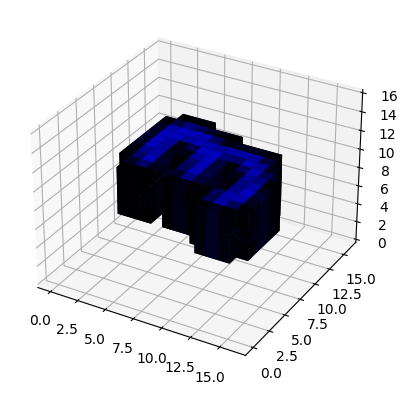

In [7]:
plot_img(next(iter(mnist_train_a))[0])

### 3. Preparation for the training

In [8]:
# Taken from https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/src/tools.py
def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

In [9]:
f = ResNet_D(16, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3).cuda()

In [10]:
iter_train_a = iter(mnist_loader_a)
iter_train_b = iter(mnist_loader_b)
iter_test = iter(mnist_loader_test)

def sample_train_a():
    global mnist_loader_a, iter_train_a
    try:
        return next(iter_train_a)[0]
    except StopIteration:
        iter_train_a = iter(mnist_loader_a)
        return next(iter_train_a)[0]

def sample_train_b():
    global mnist_loader_b, iter_train_b
    try:
        return next(iter_train_b)[0]
    except StopIteration:
        iter_train_b = iter(mnist_loader_b)
        return next(iter_train_b)[0]

def sample_test():
    global mnist_loader_test, iter_test
    try:
        return next(iter_test)[0]
    except StopIteration:
        iter_test = iter(mnist_loader_test)
        return next(iter_test)[0]

In [11]:
def save_model(e, t, F, o_t, o_F, l_t, l_F, path):
    torch.save({
                'epoch': e,
                'T_state_dict': t.state_dict(),
                'f_state_dict': F.state_dict(),
                'T_optimizer_state_dict': o_t.state_dict(),
                'f_optimizer_state_dict': o_F.state_dict(),
                'T_loss': l_t,
                'f_loss': l_F
                }, path)

In [12]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-5, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

### 4. Training loop

In [13]:
def sq_cost(X, Y):
  return (X-Y).square().flatten(start_dim=1).mean(dim=1)

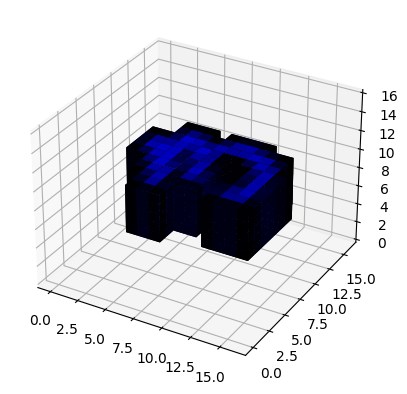

  0%|          | 0/8001 [00:00<?, ?it/s]

T_loss: -0.0045052580535411835;  f_loss: 0.007481178268790245


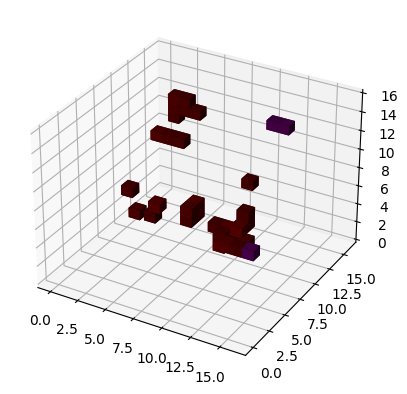

  1%|          | 100/8001 [01:07<1:30:04,  1.46it/s]

T_loss: -0.14295029640197754;  f_loss: -0.010869145393371582


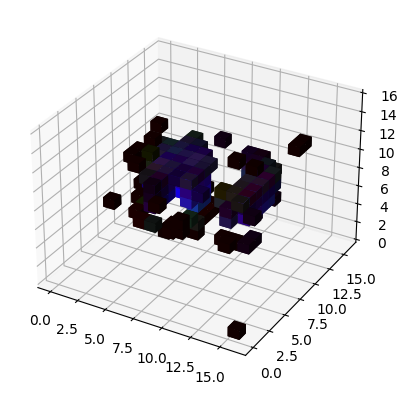

  2%|▏         | 200/8001 [02:16<1:29:39,  1.45it/s]

T_loss: -0.14443951845169067;  f_loss: -0.010915696620941162


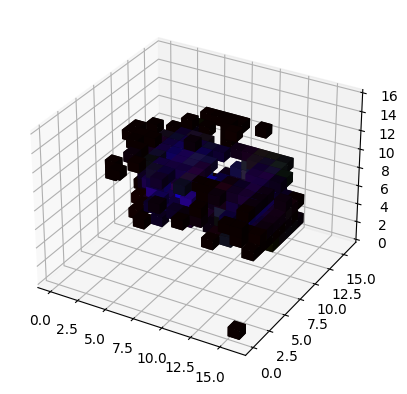

  4%|▎         | 300/8001 [03:26<1:28:26,  1.45it/s]

T_loss: -0.22443293035030365;  f_loss: -0.03289896249771118


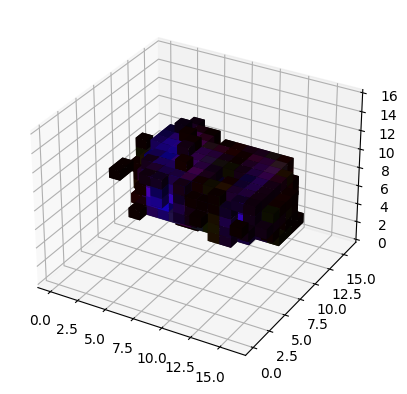

  5%|▍         | 400/8001 [04:35<1:27:43,  1.44it/s]

T_loss: -2.3265035152435303;  f_loss: 0.05967402458190918


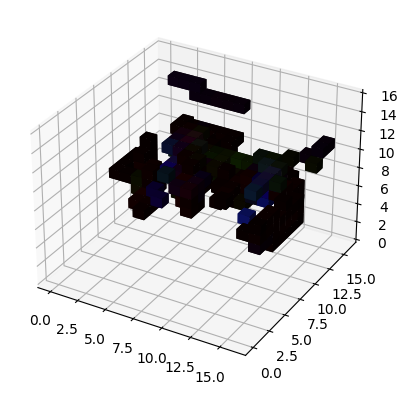

  6%|▌         | 500/8001 [05:45<1:26:21,  1.45it/s]

T_loss: -2510.12744140625;  f_loss: 631.2650146484375


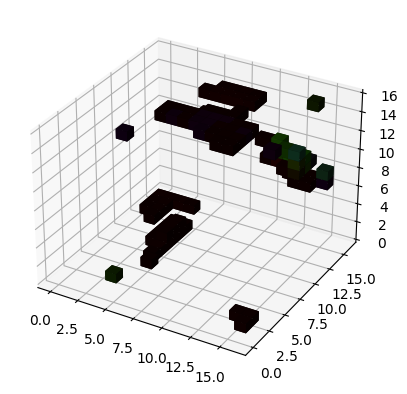

  7%|▋         | 600/8001 [06:54<1:25:20,  1.45it/s]

T_loss: -15.044547080993652;  f_loss: 0.8349208831787109


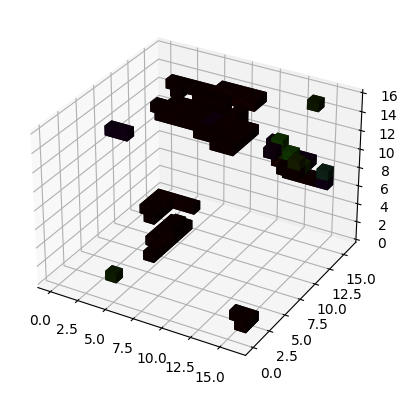

  9%|▊         | 700/8001 [08:04<1:23:44,  1.45it/s]

T_loss: 469.8709716796875;  f_loss: -21.501312255859375


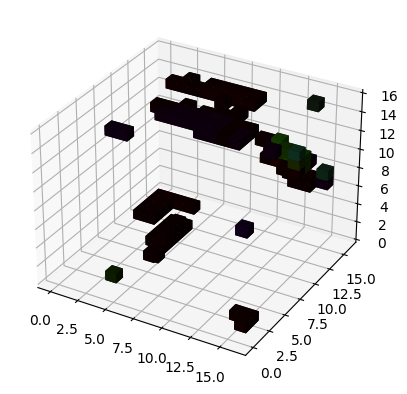

 10%|▉         | 800/8001 [09:13<1:23:09,  1.44it/s]

T_loss: -0.5309953689575195;  f_loss: 1.8640029430389404


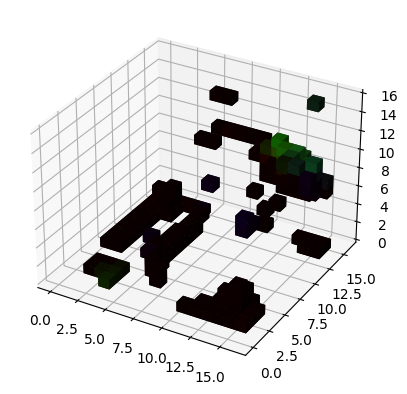

 11%|█         | 900/8001 [10:23<1:21:57,  1.44it/s]

T_loss: -19.524166107177734;  f_loss: 2.4023056030273438


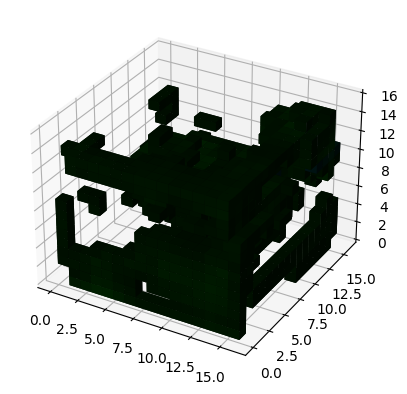

 12%|█▏        | 1000/8001 [11:32<1:20:33,  1.45it/s]

T_loss: 7.189214706420898;  f_loss: -1.969904899597168


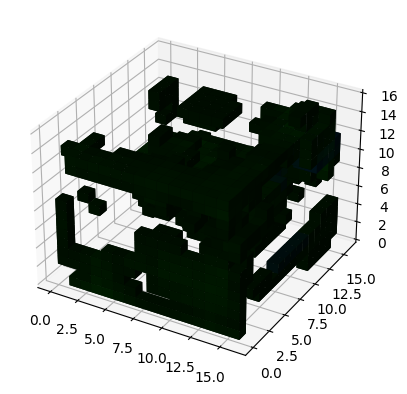

 14%|█▎        | 1100/8001 [12:42<1:19:41,  1.44it/s]

T_loss: 25.01880645751953;  f_loss: 1.644805908203125


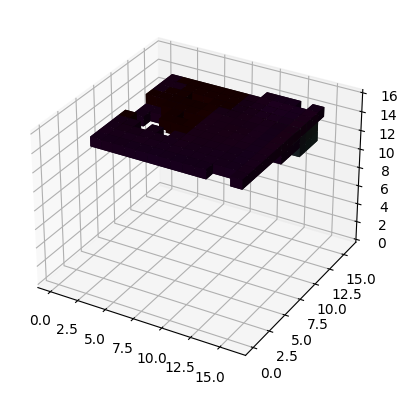

 15%|█▍        | 1200/8001 [13:52<1:18:27,  1.44it/s]

T_loss: -36.81964111328125;  f_loss: 7.860252380371094


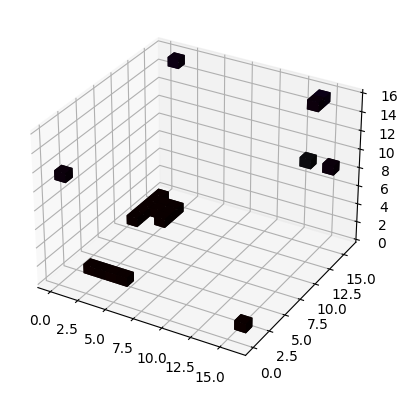

 16%|█▌        | 1300/8001 [15:01<1:17:15,  1.45it/s]

T_loss: -15.959264755249023;  f_loss: -14.842239379882812


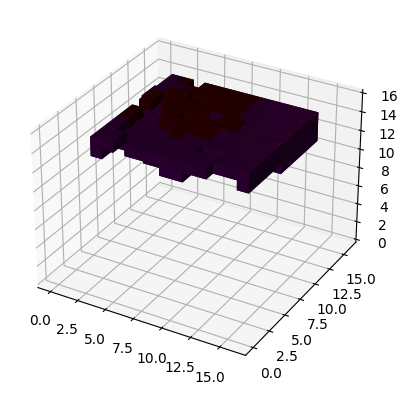

 17%|█▋        | 1400/8001 [16:11<1:15:50,  1.45it/s]

T_loss: -10.8214693069458;  f_loss: 1.4319286346435547


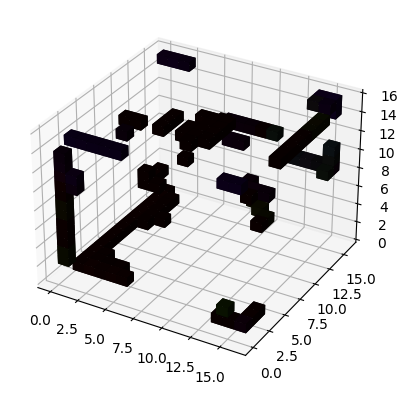

 19%|█▊        | 1500/8001 [17:20<1:15:04,  1.44it/s]

T_loss: 7.688481330871582;  f_loss: 1.2605314254760742


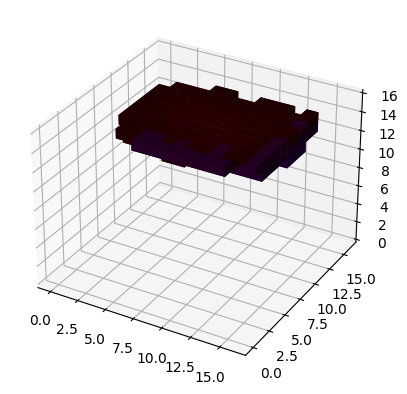

 20%|█▉        | 1600/8001 [18:30<1:13:52,  1.44it/s]

T_loss: -23.560178756713867;  f_loss: -1.2740707397460938


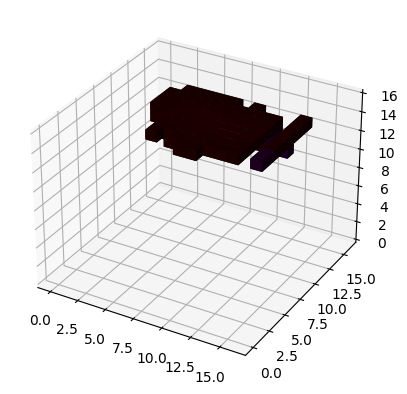

 21%|██        | 1700/8001 [19:39<1:12:37,  1.45it/s]

T_loss: -2.1810061931610107;  f_loss: -0.3339862823486328


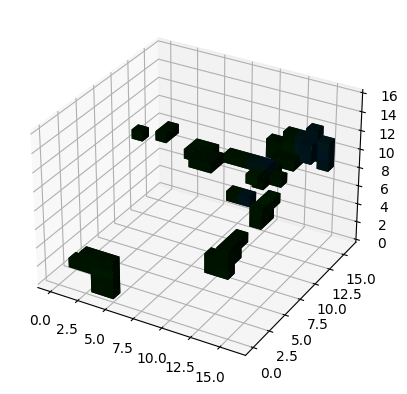

 22%|██▏       | 1800/8001 [20:48<1:11:01,  1.46it/s]

T_loss: 4.494108200073242;  f_loss: 0.5286927223205566


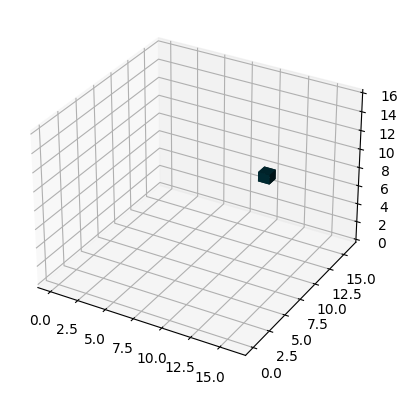

 24%|██▎       | 1900/8001 [21:58<1:10:26,  1.44it/s]

T_loss: -27.94651222229004;  f_loss: 3.6293201446533203


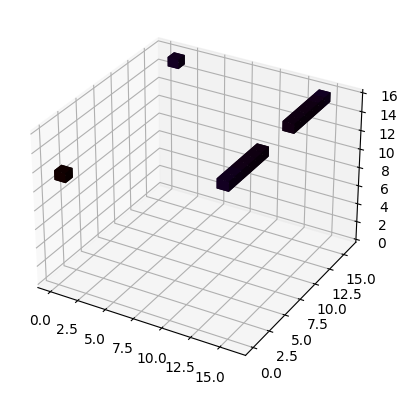

 25%|██▍       | 2000/8001 [23:07<1:09:13,  1.44it/s]

T_loss: -40.34027099609375;  f_loss: -8.680557250976562


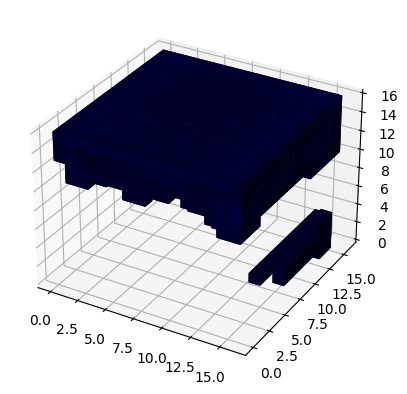

 26%|██▌       | 2100/8001 [24:17<1:07:50,  1.45it/s]

T_loss: -1059.76220703125;  f_loss: 13.057373046875


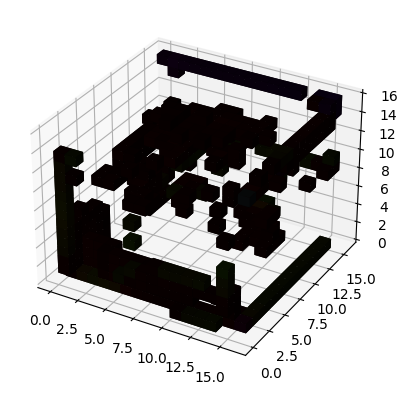

 27%|██▋       | 2200/8001 [25:27<1:06:49,  1.45it/s]

T_loss: -3362.809326171875;  f_loss: -185.221435546875


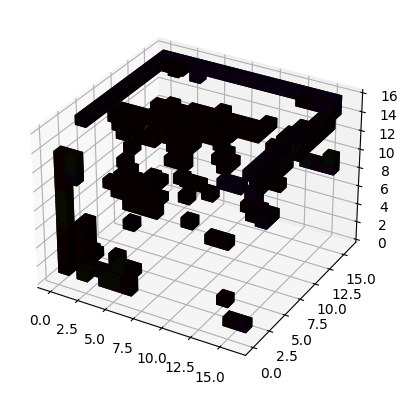

 29%|██▊       | 2300/8001 [26:36<1:05:47,  1.44it/s]

T_loss: -179.15121459960938;  f_loss: 15.50115966796875


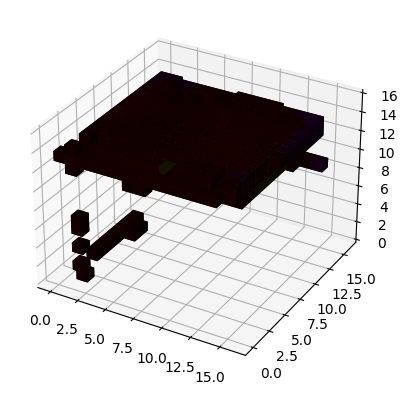

 30%|██▉       | 2400/8001 [27:46<1:04:36,  1.44it/s]

T_loss: -2025.010498046875;  f_loss: -1755.55859375


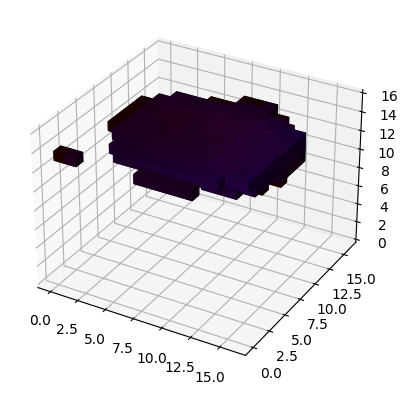

 31%|███       | 2500/8001 [28:55<1:03:15,  1.45it/s]

T_loss: -1486153.25;  f_loss: 224436.5


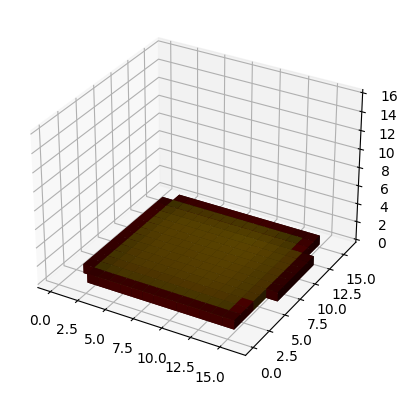

 32%|███▏      | 2600/8001 [30:05<1:02:25,  1.44it/s]

T_loss: -97392.1875;  f_loss: 13988.0625


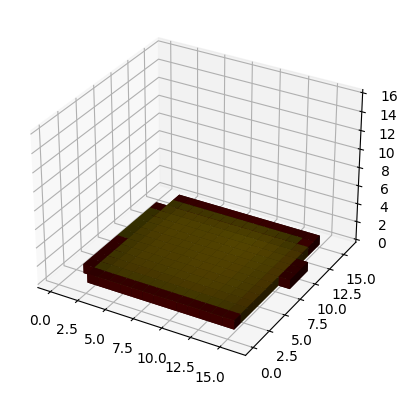

 34%|███▎      | 2700/8001 [31:14<1:01:17,  1.44it/s]

T_loss: -33931.31640625;  f_loss: 2922.0625


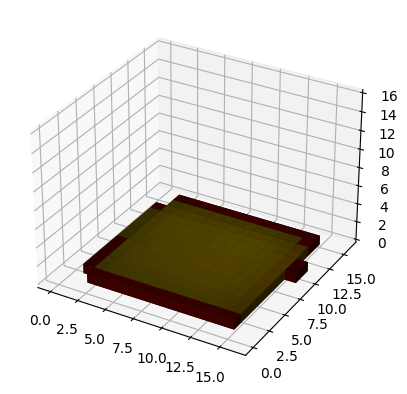

 35%|███▍      | 2800/8001 [32:24<1:00:00,  1.44it/s]

T_loss: 1303.80859375;  f_loss: -27.767578125


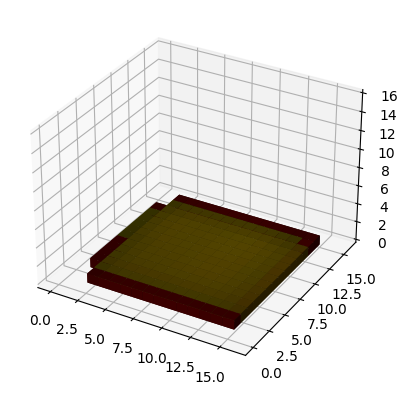

 36%|███▌      | 2900/8001 [33:33<58:48,  1.45it/s]  

T_loss: 59171.08203125;  f_loss: -3815.4375


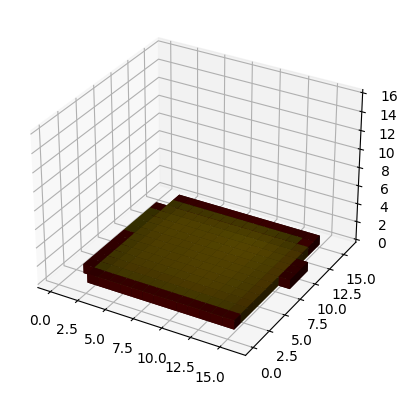

 37%|███▋      | 3000/8001 [34:43<57:39,  1.45it/s]  

T_loss: -5965.744140625;  f_loss: -14348.5478515625


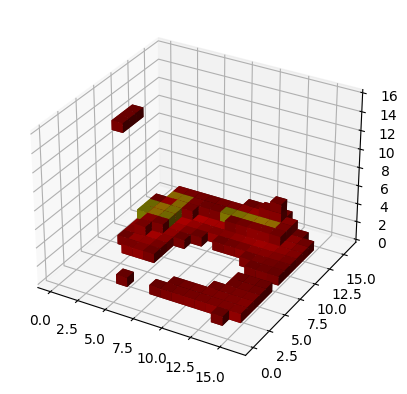

 39%|███▊      | 3100/8001 [35:52<56:33,  1.44it/s]  

T_loss: -99487.484375;  f_loss: 12963.953125


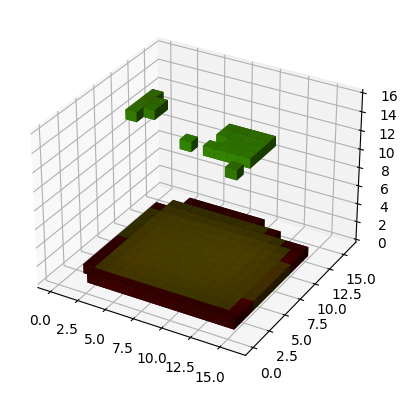

 40%|███▉      | 3200/8001 [37:02<55:20,  1.45it/s]  

T_loss: -42204.79296875;  f_loss: 8783.42578125


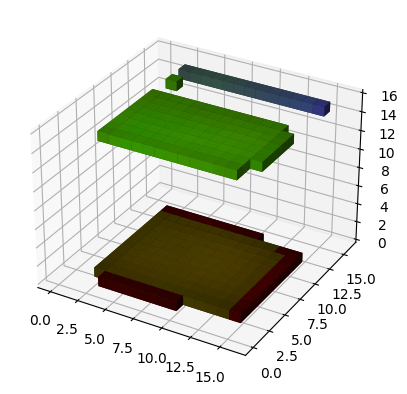

 41%|████      | 3300/8001 [38:11<54:19,  1.44it/s]  

T_loss: -19801.4140625;  f_loss: 2748.083984375


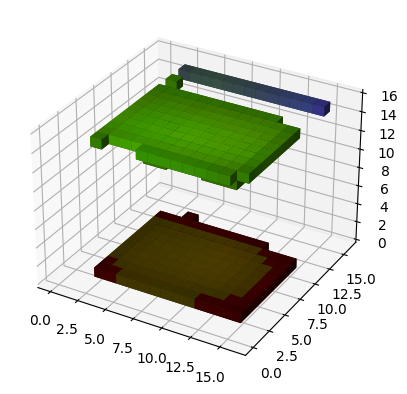

 42%|████▏     | 3400/8001 [39:21<53:04,  1.44it/s]  

T_loss: -6649.0439453125;  f_loss: 1437.1064453125


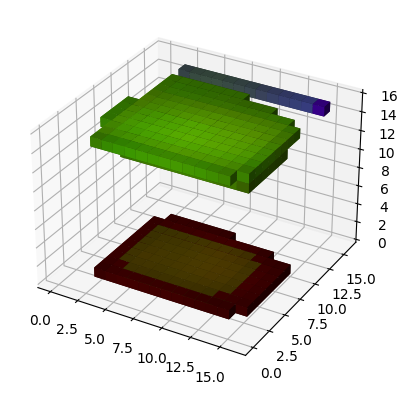

 44%|████▎     | 3500/8001 [40:30<51:55,  1.44it/s]  

T_loss: -1699.8321533203125;  f_loss: 344.6395263671875


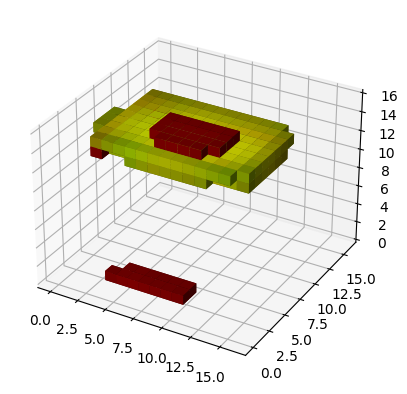

 45%|████▍     | 3600/8001 [41:40<50:36,  1.45it/s]

T_loss: -755.2615356445312;  f_loss: 358.1170654296875


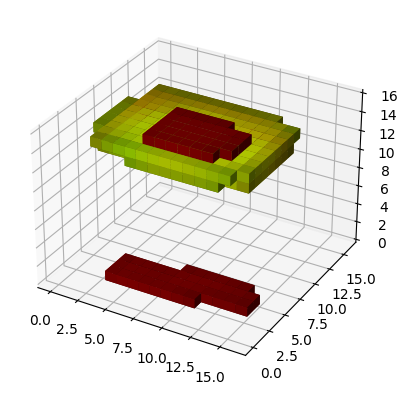

 46%|████▌     | 3700/8001 [42:50<49:40,  1.44it/s]

T_loss: -1043.8323974609375;  f_loss: 270.415771484375


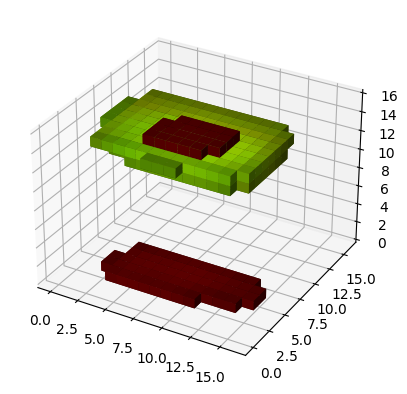

 47%|████▋     | 3800/8001 [43:59<48:28,  1.44it/s]

T_loss: -911.1801147460938;  f_loss: 184.565673828125


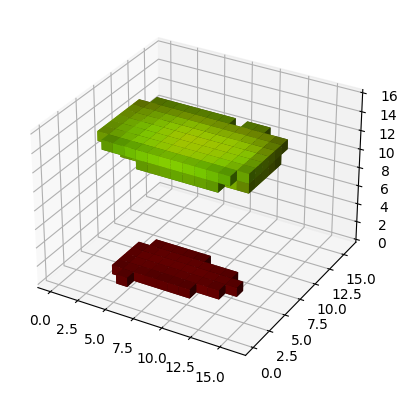

 49%|████▊     | 3900/8001 [45:08<47:09,  1.45it/s]

T_loss: -569.013427734375;  f_loss: 37.6099853515625


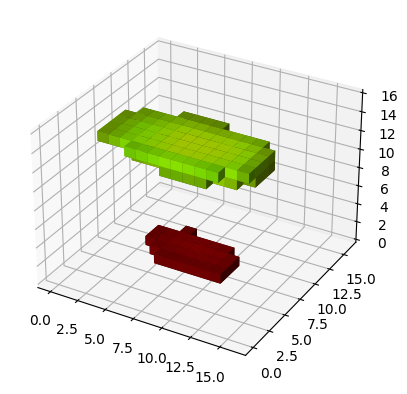

 50%|████▉     | 4000/8001 [46:18<45:53,  1.45it/s]

T_loss: -630.4755859375;  f_loss: 61.84259033203125


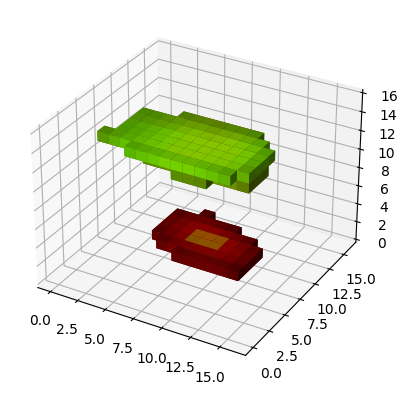

 51%|█████     | 4100/8001 [47:28<45:01,  1.44it/s]

T_loss: -472.508544921875;  f_loss: 55.987152099609375


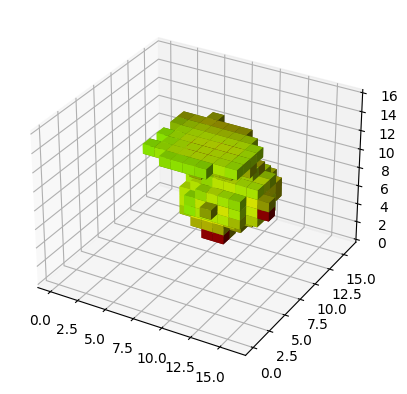

 52%|█████▏    | 4200/8001 [48:37<43:53,  1.44it/s]

T_loss: -421.7410888671875;  f_loss: 31.3848876953125


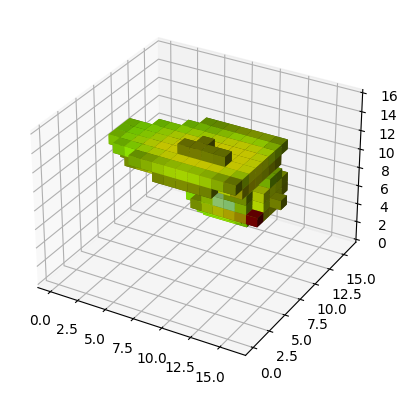

 54%|█████▎    | 4300/8001 [49:47<42:37,  1.45it/s]

T_loss: -260.2628479003906;  f_loss: 23.233322143554688


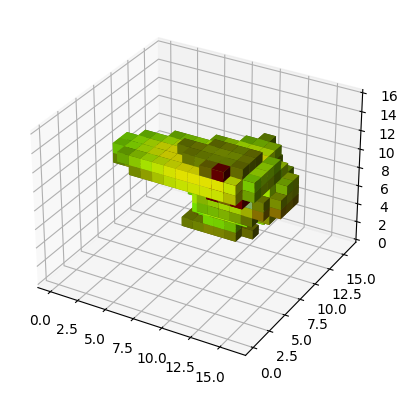

 55%|█████▍    | 4400/8001 [50:56<41:33,  1.44it/s]

T_loss: -243.51416015625;  f_loss: 24.077301025390625


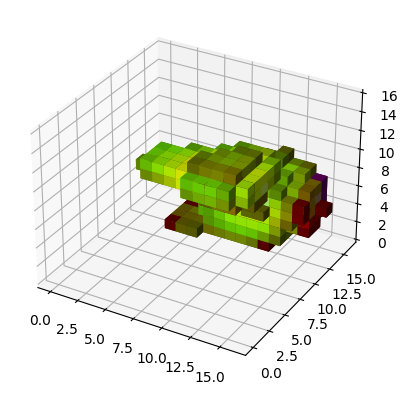

 56%|█████▌    | 4500/8001 [52:06<40:22,  1.45it/s]

T_loss: -204.55105590820312;  f_loss: 22.372543334960938


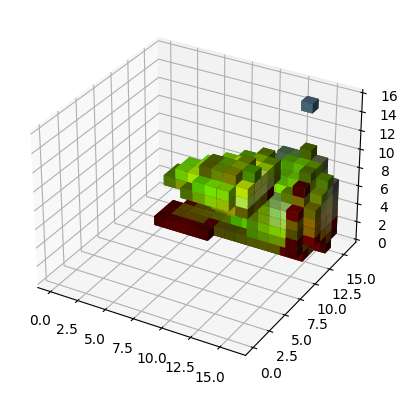

 57%|█████▋    | 4600/8001 [53:15<39:12,  1.45it/s]

T_loss: -199.7594451904297;  f_loss: 21.77410888671875


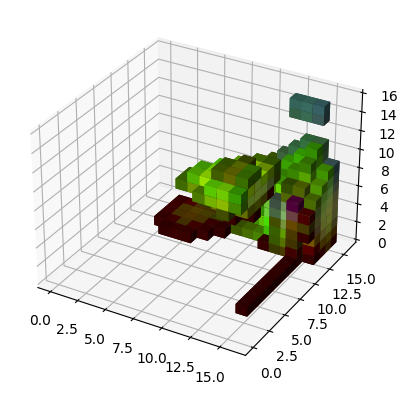

 59%|█████▊    | 4700/8001 [54:24<38:00,  1.45it/s]

T_loss: -137.87643432617188;  f_loss: 20.13829803466797


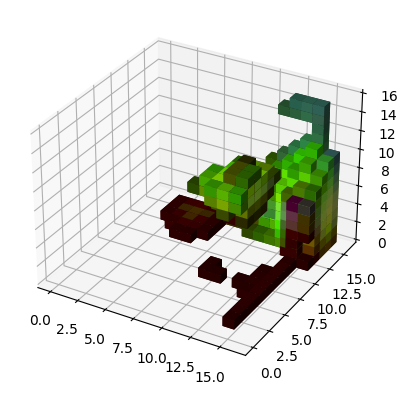

 60%|█████▉    | 4800/8001 [55:34<36:56,  1.44it/s]

T_loss: -119.69708251953125;  f_loss: 17.095924377441406


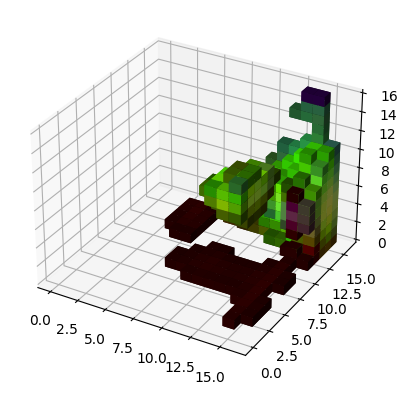

 61%|██████    | 4900/8001 [56:43<35:45,  1.45it/s]

T_loss: -111.62610626220703;  f_loss: 17.408355712890625


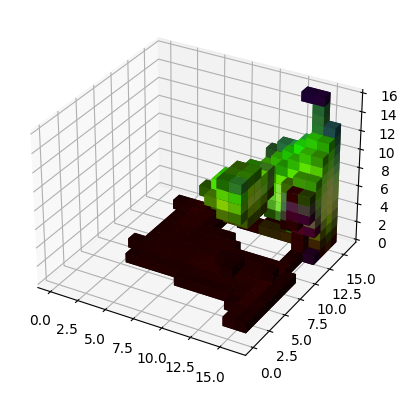

 62%|██████▏   | 5000/8001 [57:53<34:35,  1.45it/s]

T_loss: 15.984545707702637;  f_loss: -4.785360336303711


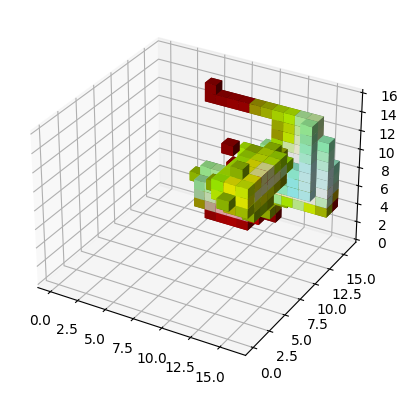

 64%|██████▎   | 5100/8001 [59:03<33:17,  1.45it/s]

T_loss: -3664.87255859375;  f_loss: 313.601806640625


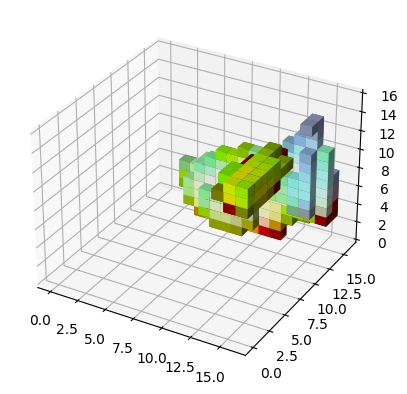

 65%|██████▍   | 5180/8001 [59:58<32:39,  1.44it/s]


KeyboardInterrupt: 

In [15]:
test_batch = sample_test()
plot_img(test_batch[0])
f_losses = []
T_losses = []

imgs = []

for step in tqdm(range(8001)):
    # clear_output(wait=True)

    # Training T, freezing f
    T.train(True)
    f.eval()
    
    for i in range(10):
        X = sample_train_a().cuda()

        T_X = T(X)
        T_loss = sq_cost(X, T_X).mean() - f(T_X).mean()
        T_opt.zero_grad()
        T_loss.backward()
        T_opt.step()
    

    # Training f, freezing T
    f.train(True)
    T.eval()

    X = sample_train_a().cuda()
    Y = sample_train_b().cuda()

    with torch.no_grad():
        T_x = T(X)
    
    f_loss = f(T_x).mean() - f(Y).mean()
    f_opt.zero_grad()
    f_loss.backward()
    f_opt.step()

    if not step % 100:
        print(f"T_loss: {T_loss}; ", end="")
        print(f" f_loss: {f_loss}")
        T_X = torch.clip(T(test_batch.cuda())[0].cpu().detach(), min=0, max=1)
        T_X[T_X < np.quantile(T_X, 0.92)] = 0
        plot_img(T_X)

    # Save OT map every 1000 steps
    if not step % 1000:
        save_model(step, T, f, T_opt, f_opt, T_loss, f_loss, f"weights/OT_{step}.pt")

    gc.collect()
    torch.cuda.empty_cache()

In [20]:
test_batch = sample_test().cuda()

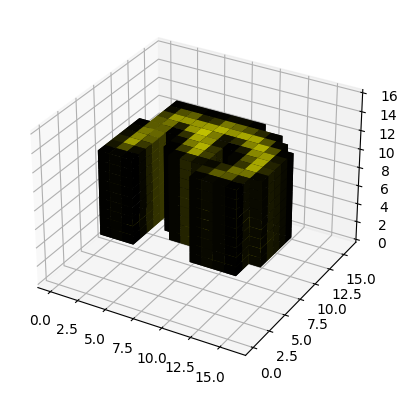

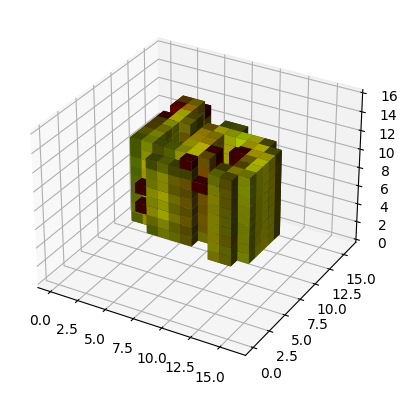

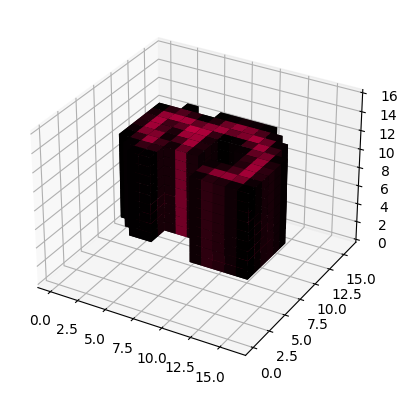

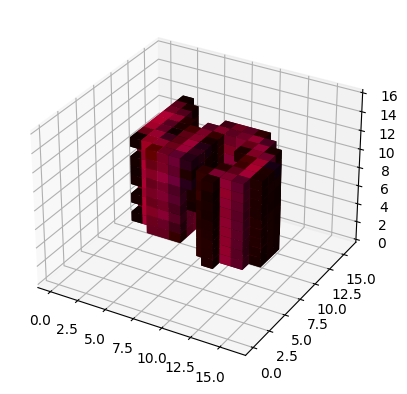

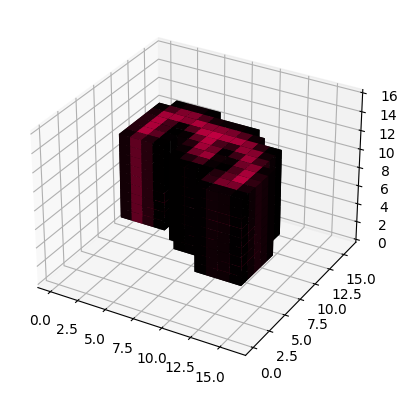

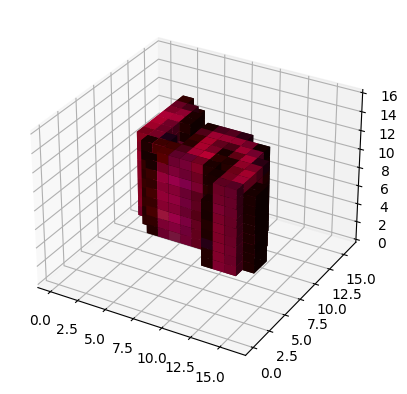

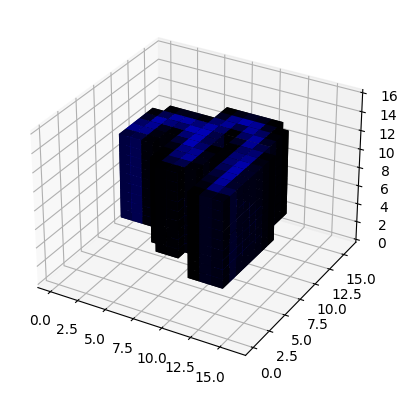

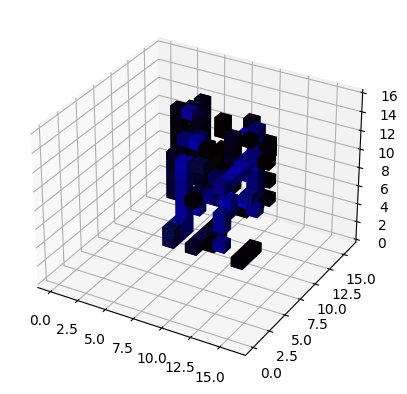

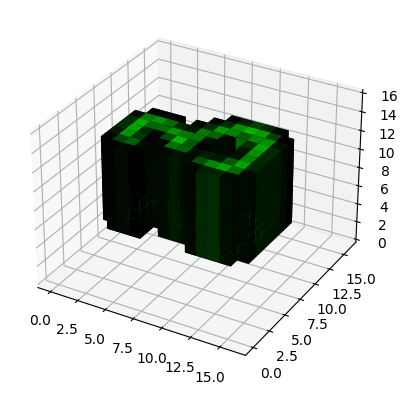

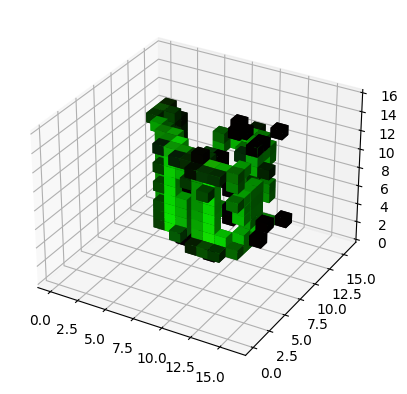

In [21]:
for i in range(5):
    plot_img(test_batch[i].cpu())

    T_X = torch.clip(T(test_batch)[i].cpu().detach(), min=0, max=1)
    T_X[T_X < np.quantile(T_X, 0.92)] = 0
    plot_img(T_X)